In [1]:
import torch
import glob
import sklearn, skimage
import pickle
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from PIL import Image,ImageOps
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale, LabelEncoder
from sklearn.model_selection import train_test_split
from skimage import io
from skimage.transform import rescale, resize
from joblib import dump, load
from torch.utils.data.dataloader import default_collate
from torch import nn
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
plt.ion()

import sklearn.decomposition
import sklearn.svm
import sklearn.neighbors

from matplotlib.pyplot import figure
from matplotlib.pyplot import plot
from matplotlib.pyplot import xlabel
from matplotlib.pyplot import ylabel
from matplotlib.pyplot import show

import numpy as np
import pandas as pd
import os
import cv2

import re
#from tqdm import tqdm

In [2]:
#DATA_PATH = '/kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/data.xlsx'
#IMG_DIR = '/kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images/'

DATA_PATH = '../archive/ODIR-5K/ODIR-5K/data.xlsx'
#IMG_DIR = 'ODIR-5K/ODIR-5K/TRAINING/'
IMG_DIR = '../archive/preprocessed_images'

In [17]:
# Cette fonction lit le fichier RAW des données et fait une analyse des diagnostiques en format free-text 
# pour en faire un codage de maladie distinguant oeil gauche et oeil droit
# les données reconstruites sont ensuite sauvegarder dans un nouveau fichier csv

def getDiagnostic(text):
    diagnostic_keyphrases = {0: ['normal fundus'], 
      1: ['nonproliferative retinopathy',
      'non proliferative retinopathy','mild nonproliferative retinopathy',
      'proliferative retinopathy','diabetic retinopathy', 'moderate non proliferative retinopathy',
      'hypertensive retinopathy', 'severe proliferative diabetic retinopathy', 'myopia retinopathy',
      'suspicious diabetic retinopathy', 'suspected diabetic retinopathy', 'myopic retinopathy'],
      2: ['glaucoma', 'suspected glaucoma', 'severe nonproliferative retinopathy',
      'proliferative diabetic retinopathy', 'suspected moderate non proliferative retinopathy'],
      3: ['cataract'],
      4: ['age-related macular degeneration', 'wet age-related macular degeneration',
      'dry age-related macular degeneration'],
      5: ['hypertensive'],
      6: ['myopi', 'pathological myopia'],
      7: ['macular epiretinal membrane',
      'epiretinal membrane',
      'drusen',
      'myelinated nerve fibers',
      'vitreous degeneration',
      'refractive media opacity',
      'spotted membranous change',
      'tessellated fundus',
      'maculopathy',
      'chorioretinal atrophy',
      'branch retinal vein occlusion',
      'retinal pigmentation',
      'white vessel',
      'post retinal laser surgery',
      'epiretinal membrane over the macula',
      'retinitis pigmentosa',
      'central retinal vein occlusion',
      'optic disc edema',
      'post laser photocoagulation',
      'retinochoroidal coloboma',
      'atrophic change',
      'optic nerve atrophy',
      'old branch retinal vein occlusion',
      'depigmentation of the retinal pigment epithelium',
      'chorioretinal atrophy with pigmentation proliferation',
      'central retinal artery occlusion',
      'old chorioretinopathy',
      'pigment epithelium proliferation',
      'retina fold',
      'abnormal pigment ',
      'idiopathic choroidal neovascularization',
      'branch retinal artery occlusion',
      'vessel tortuosity',
      'pigmentation disorder',
      'rhegmatogenous retinal detachment',
      'macular hole',
      'morning glory syndrome',
      'atrophy',
      'laser spot',
      'arteriosclerosis',
      'asteroid hyalosis',
      'congenital choroidal coloboma',
      'macular coloboma',
      'optic discitis',
      'oval yellow-white atrophy',
      'wedge-shaped change',
      'wedge white line change',
      'retinal artery macroaneurysm',
      'retinal vascular sheathing',
      'suspected abnormal color of  optic disc',
      'suspected retinal vascular sheathing',
      'suspected retinitis pigmentosa',
      'silicone oil eye',
      'punctate inner choroidopathy',
      'myopic maculopathy',
      'optic disk epiretinal membrane',
      'lens dust',
      'retinal pigment epithelium atrophy',
      'old choroiditis',
      'fundus laser photocoagulation spots',
      'diffuse retinal atrophy',
      'old central retinal vein occlusion',
      'intraretinal hemorrhage',
      'peripapillary atrophy',
      'choroidal nevus',
      'macular pigmentation disorder',
      'diffuse chorioretinal atrophy']}
    
    diagnostics = re.split('， *|, *', text)
    
    l = []
    dic = {}
    for d in diagnostics:
        for key, values in diagnostic_keyphrases.items():
            if d in values and not key in l:
                l.append(key)
    return l

def generateCSV(csvName, discardNoLabels = False, discardMoreOneLabel = False, filters = []):
    data = pd.read_excel(DATA_PATH)
    
    new_data = []
    for i, row in data.iterrows():
        new_row = [row['Patient Age'], row['Patient Sex'], row['Left-Fundus']]
        labels = getDiagnostic(row['Left-Diagnostic Keywords'])
        if (not discardNoLabels or len(labels) > 0) and (not discardMoreOneLabel or len(labels) <= 1):
            new_row.append(labels[0])
            if len(filters) == 0:
                new_data.append(new_row)
            else:
                for f in filters:
                    if f in labels:
                        new_data.append(new_row)
                        break
            
        new_row = [row['Patient Age'], row['Patient Sex'], row['Right-Fundus']]
        labels = getDiagnostic(row['Right-Diagnostic Keywords'])
        if (not discardNoLabels or len(labels) > 0) and (not discardMoreOneLabel or len(labels) <= 1):
            new_row.append(labels[0])
            if len(filters) == 0:
                new_data.append(new_row)
            else:
                for f in filters:
                    if f in labels:
                        new_data.append(new_row)
                        break
    
    key_columns = ['Patient Age','Patient Sex', 'Image', 'Label'] 

    df = pd.DataFrame(new_data)
    df.to_csv(csvName, header=key_columns, index=False, encoding='utf-8')

In [18]:
generateCSV('full_df.csv', discardNoLabels = True, discardMoreOneLabel = True)

In [5]:
IMG_SIZE = 512

In [6]:
# Ensemble de fonctions permettant de transformer l'image pour un meilleur entrainement par les modeles 
# d'apprentissages

# conversion image en TensorFlow pour librairie Torch/TorchVision
def preprocess_PCA(image):
    image = np.array(image)
    reshapeSize = IMG_SIZE * IMG_SIZE
    image = np.reshape(image, (1, reshapeSize))
    
    with open ('ModelPCA.joblib', 'rb') as f:
        ModelPCA2 = load(f)
        
    image = ModelPCA2.transform(image)
    image = Image.fromarray(image)
    return image

# conversion de l'image pour enlever des parties d'image non souhaité comme les bordures de l'image
def preprocess_image_Crop(image):
    image = np.asarray(image)
    
    # Remove vertical black borders (the image must be already normalized)
    sums = image.sum(axis=0)
    sums = sums.sum(axis=1)
    filter_arr = []
    for s in sums:
        if s == 0:
            filter_arr.append(False)
        else:
            filter_arr.append(True)
    image = image[:, filter_arr]
    
    # Crop to a square shape
    h = image.shape[0]
    w = image.shape[1]
    if h < w:
        x = (w - h)//2
        image = image[:, x:x+h, :]        
    elif h > w:
        x = (h - w)//2
        image = image[x:x+w, :, :]    
    else:
        pass
    
    image = Image.fromarray(image)
    return image

# conversion de l'image pour obtenir une resolution (taille) identique entre toutes les images.
def preprocess_image_Resize(image):
    image = np.asarray(image)
    
    # redimension de l'image pour avoir meme dimension entre toutes les images (à cause image resolution differentes)
    # et conversion de la couleur de l'image car par defaut cv2 lit image en couleur bleue
    # dans le resize, le ration = 1 par defaut car hauteur pixel = largeur pixel
    image = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), (IMG_SIZE, IMG_SIZE))
    
    image = Image.fromarray(image)
    return image

def scaleRadius(img, scale):
    toto = int(img.shape[0] / 2)
    x = img[toto, :, :].sum(1)
    r = (x > x.mean() / 10).sum() / 2
    s = scale * 1.0 / r
    return cv2.resize(img, (0, 0), fx=s, fy=s)

# implementation pseudo-code Ben Graham qui permet de trasnformer une image en noir et blanc avec amélioration des
# constrastes, lissage des variations de couleurs du à un éclairtage photographique different
def preprocess_image_Ben(image):
    image = np.asarray(image)
    scale = 320
    
    # redimensionnement de l'image à un rayon donné
    image = scaleRadius(image, scale)
    
    # on soustrait la couleur moyenne pour la mapper sur 50% de gris de façon à mieux faire ressortir les constrastes
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0, 0), scale / 30), -4, 128)
    
    # on enleve 10% des bordures
    b = np.zeros(image.shape)
    
    cv2.circle(b, (int(image.shape[1] / 2), int(image.shape[0] / 2)), int(scale * 0.9), (1, 1, 1), -1, 8, 0)
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)
    return image

# conversion de l'image en nuances de gris
def to_grayscale(image):
    # passage en noir et blanc
    image = ImageOps.grayscale(image)
    return image


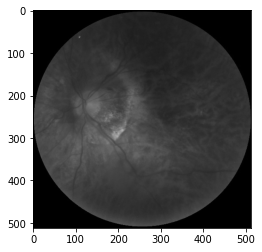

In [7]:
# Exemple d'image après traitement/transformation (crop, resize, nuance gris)
file_name = str(13) + '_left.jpg'

filename = glob.glob(os.path.join(IMG_DIR,file_name))
image = Image.open(filename[0])
image = preprocess_image_Crop(image)
image = to_grayscale(image)
image = preprocess_image_Resize(image)

image.save(str(810) + "_" + file_name)
plt.imshow(image)
plt.show()


In [10]:
# class data pour lire à la volée les images X du dataset et les labels y
class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, data_dir, transform):
        'Initialization'

        """
        to_drop = ['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus',
           'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'N', 'D', 'G',
           'C', 'A', 'H', 'M', 'O', 'filepath', 'target']
        data = data.drop(columns = to_drop)
        """

        data = pd.read_csv('full_df.csv')
  
        my_dir = data_dir+'archive/ODIR-5K/ODIR-5K/Training Images/'
  
        my_list = glob.glob(os.path.join(my_dir, '*.jpg'))
        
        ListeMaladie = ["['N']", "['D']", "['G']", "['C']", "['A']", "['H']", "['M']", "['O']"]
    
        filename_list = []
        labels_list = []
        # test si maladie unique sur un oeil sinon on rejete la donnée y,X
        for i in range(len(data)):
            if data['Label'][i] in ListeMaladie:
                labels_list.append(data['Label'][i])
                filename_list.append(data['Image'][i])
        
        print(labels_list[0][2])
        
        self.labels = labels_list
        self.list_IDs = filename_list
        self.transform = transform

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.labels)

    def __getitem__(self, index):
        ID = self.list_IDs[index]
        img_path = '../archive/ODIR-5K/ODIR-5K/Training Images/' + ID
        print("processing", img_path)
        img = Image.open(img_path)

        img_transformed = self.transform(img)

        labels_unique = np.unique(self.labels)
      
        label = self.labels[index]
        label = np.where(labels_unique == label)[0][0]
        
        X = img_transformed
        y = label
        
        return X, y

# ensemble de module 'transformer' predefinies selon les transformations que l'on souhaite apporter
# sur les images lors de la lecture du dataset
my_transforms_gray_scale = transforms.Compose ([
    preprocess_image_Crop,
    preprocess_image_Resize,
    #to_grayscale,
#    preprocess_PCA,
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

my_transforms_ben_gray = transforms.Compose ([
    preprocess_image_Crop,
    preprocess_image_Ben,
    preprocess_image_Resize,
    to_grayscale,
    #preprocess_PCA,
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

my_transforms_ben = transforms.Compose ([
    preprocess_image_Crop,
    preprocess_image_Ben,
    preprocess_image_Resize,
    #preprocess_PCA,
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                          std=[0.229,0.224,0.225])
])

my_transforms_normal = transforms.Compose ([
    preprocess_image_Resize,
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                          std=[0.229,0.224,0.225])
])

In [11]:
# TEST
# exemple d'instanciation du dataset avec lecture à la volée
dataset = Dataset(data_dir='../', transform=my_transforms_ben_gray)
print("taille", len(dataset))

##for img, label in dataset:
##    print (type(img))


C
taille 6195


processing ../archive/ODIR-5K/ODIR-5K/Training Images/2370_left.jpg
type <class 'torch.Tensor'>
shape : torch.Size([1, 512, 512])


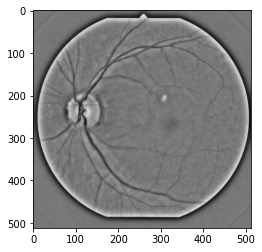

In [36]:
training_data_size = 0.8
train_size = int(training_data_size * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size,test_size])

train_loader = DataLoader(train_dataset, num_workers=0, shuffle=True)
test_loader = DataLoader(test_dataset, num_workers=0, shuffle=False)


#for (image_batch, labels_batch) in enumerate (train_loader):
image_batch, labels_batch = next(iter(train_loader))
print("type", type(image_batch))
firstimage = image_batch[0]
print("shape :", firstimage.shape)
#firstimage = np.reshape(firstimage, (512, 512, 1))
plt.imshow(firstimage.permute(1, 2, 0), cmap='gray')
plt.show()
#print(firstimage.shape)
        

In [17]:
# Test du dataset/dataloader avec le batch
##for batch_idx, (data, target) in enumerate(train_loader):
##     print("target", target)

In [1]:
# Cette classe permet le chargement de la base de données images (X) et label (y) afin de faire des analyse de
# reduction de dimensionnalité (PCA, SelectKbest) avec utilisation librairie SkLearn
class PreProcessingAnalysis:
    def __init__(self,transform, transformtensor):
      
        self.transform=transform
        self.transformtensor=transformtensor
        print("initialiation preprocessing")

    def DataLoad (self):
        data_dir=''
        data = pd.read_csv('full_df.csv')
  
        my_dir = data_dir+'preprocessed_images/'
  
        my_list = glob.glob(os.path.join(my_dir,'*.jpg'))
        
        ListeMaladie=["['N']", "['D']", "['G']", "['C']","['A']", "['H']","['M']","['O']"]

        left_labels_list=[]
        right_labels_list=[]
        left_name_list=[]
        right_name_list =[]
        print("chargement données démarrage")
        # test si maladie unique sur un oeil sinon on rejete la donnée y,X
        for i in range (len (data)):
            if data['Left Text'][i] in ListeMaladie:
                left_labels_list.append(data['Left Text'][i])
                left_name_list.append(data['Left-Fundus'][i])
                
            if data['Right Text'][i] in ListeMaladie:
                right_labels_list.append (data['Right Text'][i])
                right_name_list.append (data['Right-Fundus'][i])
            
        filename_list = np.concatenate((right_name_list, left_name_list), axis=None)
        labels_list = np.concatenate((right_labels_list, left_labels_list), axis=None)
        
        labels = labels_list
        list_IDs = filename_list
        X=[]
        y=[]
        for index in range (len(labels)):
            # Select sample
            ID = list_IDs[index]
            print (index)
            image=io.imread ('preprocessed_images/'+ID)
            image=self.transform(image)
            image=np.asarray (image)
            X.append(image)
            y.append(labels[index])
        print("chargement données terminé")   
        Yencode=LabelEncoder()
        y=Yencode.fit_transform (y)
        return X, y

    # mise des donnees (image) au format SkLearn (2D)
    def formatForSkLearn (self,X,y):
        # compatibilite format pour lecture par module sklearn (PCA, SelectKbest) : dimension 2D
        X=np.array(X)
        y=np.array(y)

        # on met X (les intensités de niveaux de gris) entre 0 et 1
        X_tmp=X.max ()
        X_norm=X/X_tmp

        # remise au format 2D
        TailleReshape=IMG_SIZE*IMG_SIZE
        X2D = np.reshape (X_norm, (X_norm.shape[0], TailleReshape))
 
        return X2D,y

    # entrainement du modele PCA puis stockage persistent (fichier)
    def fitAndStoreModelPCA (self,X,y, nb_composants):
        ModelPCA = sklearn.decomposition.PCA(n_components=nb_composants) ## TODO
        ModelPCA.fit(X)
        with open ("ModelPCA.joblib", 'wb') as f:
            dump (ModelPCA,f)
     
        
    # chargement du modele PCA à partir fichier (donnee persistante) et mise au format TensorFlow pour
    # utilisation dans librairies Torch/TorchVision
    def LoadAndTransformPCAtoTensor (self,X,y):      
        with open ('ModelPCA.joblib', 'rb') as f:
            ModelPCA2=load (f)    
        X=ModelPCA2.transform(X)
        X=self.transformtensor(X)
        return X,y
        


In [72]:
# sequence pour entrainer et stocker le modele en stockage persistent
TransformPreprocessing = transforms.Compose ([
    preprocess_image_Ben,
    preprocess_image_Resize,
    to_grayscale,
])
TransformTensor = transforms.Compose ([
    transforms.ToTensor(),
])
Preprocessing = PreProcessingAnalysis (transform=TransformPreprocessing, transformtensor=TransformTensor)
X,y=Preprocessing.DataLoad()
X,y=Preprocessing.formatForSkLearn (X,y)
Preprocessing.fitAndStoreModelPCA (X,y, nb_composants=4)

initialiation preprocessing
chargement données démarrage
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
chargement données terminé


In [73]:
# sequence pour loader le model PCA qui etait stocker de facon persistante et le mettre en format TensorFlow

TransformPreprocessing = transforms.Compose ([
    preprocess_image_Ben,
    preprocess_image_Resize,
    to_grayscale,
])
TransformTensor = transforms.Compose ([
    transforms.ToTensor(),
])
Preprocessing = PreProcessingAnalysis (transform=TransformPreprocessing, transformtensor=TransformTensor)
X,y=Preprocessing.DataLoad()
X,y=Preprocessing.formatForSkLearn (X,y)
X,y=Preprocessing.LoadAndTransformPCAtoTensor (X,y)



initialiation preprocessing
chargement données démarrage
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
chargement données terminé


In [8]:

def RechercheModelPCA():
    TransformPreprocessing = transforms.Compose ([
    preprocess_image_Ben,
    preprocess_image_Resize,
    to_grayscale,
    ])
    TransformTensor = transforms.Compose ([
    transforms.ToTensor(),
    ])
    Preprocessing = PreProcessingAnalysis (transform=TransformPreprocessing, transformtensor=TransformTensor)
    X,y=Preprocessing.DataLoad()

    X,y=Preprocessing.formatForSkLearn (X,y)
    varianceExplained=0.95
 
    preProc = sklearn.decomposition.PCA(n_components=varianceExplained) 
  
    preProc.fit(X)
    print("nombre de composants retenus pour variance 0.95:",preProc.components_.shape[0])

    CumulativeExplainedVariance = np.cumsum(preProc.explained_variance_ratio_)
    plt.plot(CumulativeExplainedVariance)
    plt.ylim([0,1])
    


initialiation preprocessing
chargement données démarrage
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
2

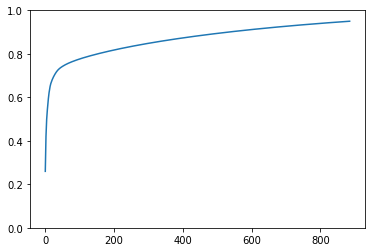

In [9]:
RechercheModelPCA()

In [94]:
def RechercheModelKbest():
    TransformPreprocessing = transforms.Compose ([
    preprocess_image_Ben,
    preprocess_image_Resize,
    to_grayscale,
    ])
    
    Preprocessing = PreProcessingStep (transform=TransformPreprocessing)
    X,y=Preprocessing.DataLoad()
    X,y=Preprocessing.formatForSkLearn (X,y)
    chi2(X,y)
    nb_features=100
    selector=SelectKBest (chi2, k=nb_features)
    X=selector.fit (X,y)
    score=selector.scores_[selector.get_support ()]
    Yencode=LabelEncoder()
    y=Yencode.fit_transform (y)
    print (score)

In [96]:
RechercheModelKbest()

initialiation preprocessing
chargement données démarrage
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
chargement données terminé
[2.49762183 2.53221014 2.64987541 2.52181543 2.75397381 2.65230997
 2.66944546 2.4556169  2.60168514 2.76467269 2.62241838 2.65199858
 2.65189031 2.52231526 2.51412476 2.43261713 3.04482701 2.71215042
 2.61086617 2.49207589 2.46864978 2.46970768 2.89623441 2.88134295
 3.38111793 2.68601785 3.00280405 2.44896872 2.43441291 2.58352568
 2.91974777 3.27625515 2.49168267 2.43458503 3.0907865  2.8560194
 3.20997599 2.4356599  2.6737523  2.98755981 3.25905899 2.63804673
 2.49212379 3.42215147 2.79319099 3.29058898 3.05338024 2.94917104
 3.40981787 2.50526611 3.31373743 2.87337071 3.15586303 2.80770335
 2.98888682 3.49893559 3.4908555  2.7794131  2.91243576 2.57357253
 2.42830371 2.73235079 3.02044981 3.24325719 3.13303325 3.18670082
 4.18137287 2.47425661 3.44397002 3.79755196 3.11284482 2.87471938
 3.15666803 2.8